# Implementing an ETS model in JAX

In this notebook I demonstrate my [JAX](https://jax.readthedocs.io/en/latest/index.html) implementation of the [ETS variant commonly denoted as $(A_d, A)$](https://otexts.com/fpp2/taxonomy.html), which has an additive damped trend and an additive seasonality component.
JAX is a high performance tensor library that offers functionalities like automatic differntiation, JIT compilation while having a familiar NumPy-like interface. However, there are some caveats, for example it only allows [pure functions](https://en.wikipedia.org/wiki/Pure_function) (so no side effects are allowed).

The main goal of this notebook is to explore JAX functionalities, especially [lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html), which offers a convenient way around writing for-loops.

A much more detailed introduction to ETS models can be found in [Forecasting: Principles and Practice](https://otexts.com/fpp2/).

## Imports and Setup

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.lax import scan
from jax.scipy.optimize import minimize
import jaxopt
from functools import partial
import pandas as pd

matplotlib.style.use("ggplot")
plt.rcParams["figure.figsize"] = [10, 4]

rng_key = jax.random.PRNGKey(seed=42)

## Data Loading
We will use the AirPassangers dataset.

<Axes: xlabel='date'>

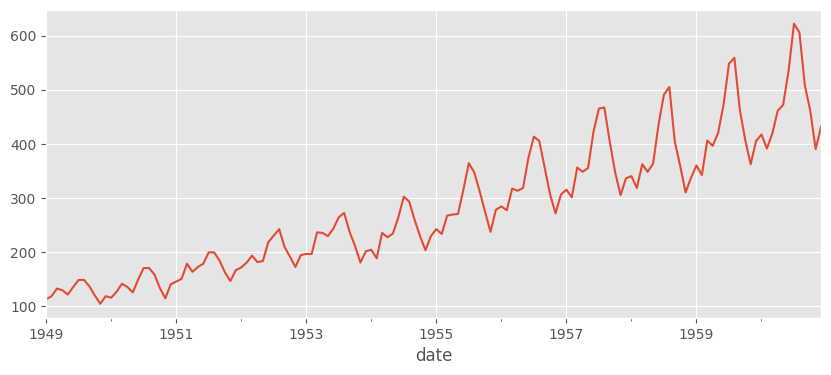

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv"
y = pd.read_csv(
    url,
    parse_dates=["date"],
).set_index("date").sort_index()["value"]
y_train = jnp.array(y)[:-12]
y_test = jnp.array(y)[-12:]

y.plot()

## [The scan function](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)
Let's start with a quick run down on how the scan function works. A crude Python implementation of it would look like this:
```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```
Here, `f` takes `carry`, which can be thought of as a state and an element `x` of `xs`, and returns a transformed `carry` and `y`. The scan function loops through the sequence `xs`, applying `f` to each element and updating the `carry` accordingly.

As an example we will calculate the square of cumulative sum of an integer sequence. Note that this implementation is not a very efficient one, we do it this way only for the sake of presentation.

In [ ]:
xs = jax.random.randint(rng_key, (100,), minval=-100, maxval=100)

def cumsum_squared(xs):
  def transition_fn(carry, x):
    previous_cumsum = carry
    cumsum = previous_cumsum + x  # Update carry
    y = cumsum ** 2  # Calculate y
    return cumsum, y

  return scan(
      transition_fn,
      init=0,
      xs=xs,
  )

assert jnp.all(jnp.cumsum(xs) ** 2 == cumsum_squared(xs)[1])

## Implementing the model
We are ready to start implementing the model, which is given by

\begin{aligned}
y_t &= l_{t-1} + \varphi b_{t-1} + s_{t - m} + \varepsilon_{t}, \\
l_t &= l_{t - 1} + \varphi b_{t - 1} + \alpha \varepsilon_t, \\
b_t &= \varphi b_{t-1} + \beta \varepsilon_t, \\
s_{t} &= s_{t - m} + \gamma \varepsilon_t.
\end{aligned}

The conditional one step ahead expectation is given by
\begin{aligned}
\mu_{y, t} = l_{t-1} + \varphi b_{t-1} + s_{t - m},
\end{aligned}
and the conditional $h$ steps ahead expectation by

\begin{aligned}
\hat{y}_{t + h} = l_{t} + \sum_{i=0}^h\varphi^i b_{t-1} + s_{t - \bigl\lceil \frac{h}{m} \bigr\rceil m + h}.
\end{aligned}
The later one might seem a bit obnoxious, but it can be derived from the model using $\mathbb{E}(\varepsilon) = 0$. Luckily, in our approach it suffices to always forecast one step ahead.

In [ ]:
def transition_fn(carry, obs, alpha, beta, gamma,  phi):
  epsilon, level, trend, season = carry

  forecast = level + trend + season[0]
  new_epsilon = jax.lax.cond(
      jnp.isnan(obs),
      lambda: 0.0,
      lambda: obs - forecast,
  )
  new_level = level + trend + alpha * epsilon
  new_trend = phi * trend + beta * epsilon
  new_season = jnp.roll(season.at[0].set(season[0] + gamma * epsilon), -1)

  return (new_epsilon, new_level, new_trend, new_season), forecast

Two things to mention:


1. When `obs` is `nan`, we want to return the conditional one step ahead expectation. To do this, we used the `jax.lax.cond` condition handler. This is equivalent to
`0.0 if jnp.isnan(obs) else obs - forecast`, however [if-else statements are not allowed in `jit`-compiled functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit).
2. Since JAX requires functions to be pure, [mutation of variables is not allowed](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#in-place-updates), i.e.
```python
season[0] = season[0] + gamma * epsilon
```
would yield an error. Instead, we update the array using the syntax `.at[idx].set(y)`.




## Prediction and optimization

Predicting is now as easy as scanning using some `initial_state`. For optimization of parameters I used LBFGS from the [jaxopt](https://github.com/google/jaxopt) library with mean squared error as a loss function, however [other loss functions can also be considered](https://openforecast.org/adam/ADAMETSEstimationLikelihood.html).

We remark that constraints on the parameters could (and should) be imposed and the initial state should be optimized, instead of setting it heuristically, however we won't bother with that, since that is not the focus of this notebook. Again, I refer the reader to [Forecasting: Principles and Practice Chapter 8.6](https://otexts.com/fpp3/ets-estimation.html).

In [ ]:
@jax.jit
def predict(y, coeffs, initial_state):
  return scan(
      partial(
          transition_fn,
          alpha=coeffs[0],
          beta=coeffs[1],
          gamma=coeffs[2],
          phi=coeffs[3],
      ),
      initial_state,
      y,
  )

@jax.jit
def squared_error(y, yhat):
  return (y - yhat) ** 2

@jax.jit
def opt_coeffs(
    y,
    n_periods,
    initial_state,
  ):
  def loss_func(coeffs):
    return squared_error(y, predict(y, coeffs, initial_state)[1]).mean()

  x_star = jaxopt.LBFGS(fun=loss_func, maxiter=500).run(jnp.ones(4) / 10)

  return x_star.params

Note that on the first run, `opt_coeffs` function is compiled, which slows things down.

In [ ]:
%%time
n_periods = 12
initial_state = (1.0, .0, .0, y_train[:12].astype("float32"))

coeffs = opt_coeffs(y_train, n_periods, initial_state)

However, on later runs it should be pretty fast, especially on inputs of the same size, which sounds restrictive, but it can be solved using padding.

In [ ]:
%%timeit
coeffs = opt_coeffs(y_train, n_periods, initial_state)

54.7 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


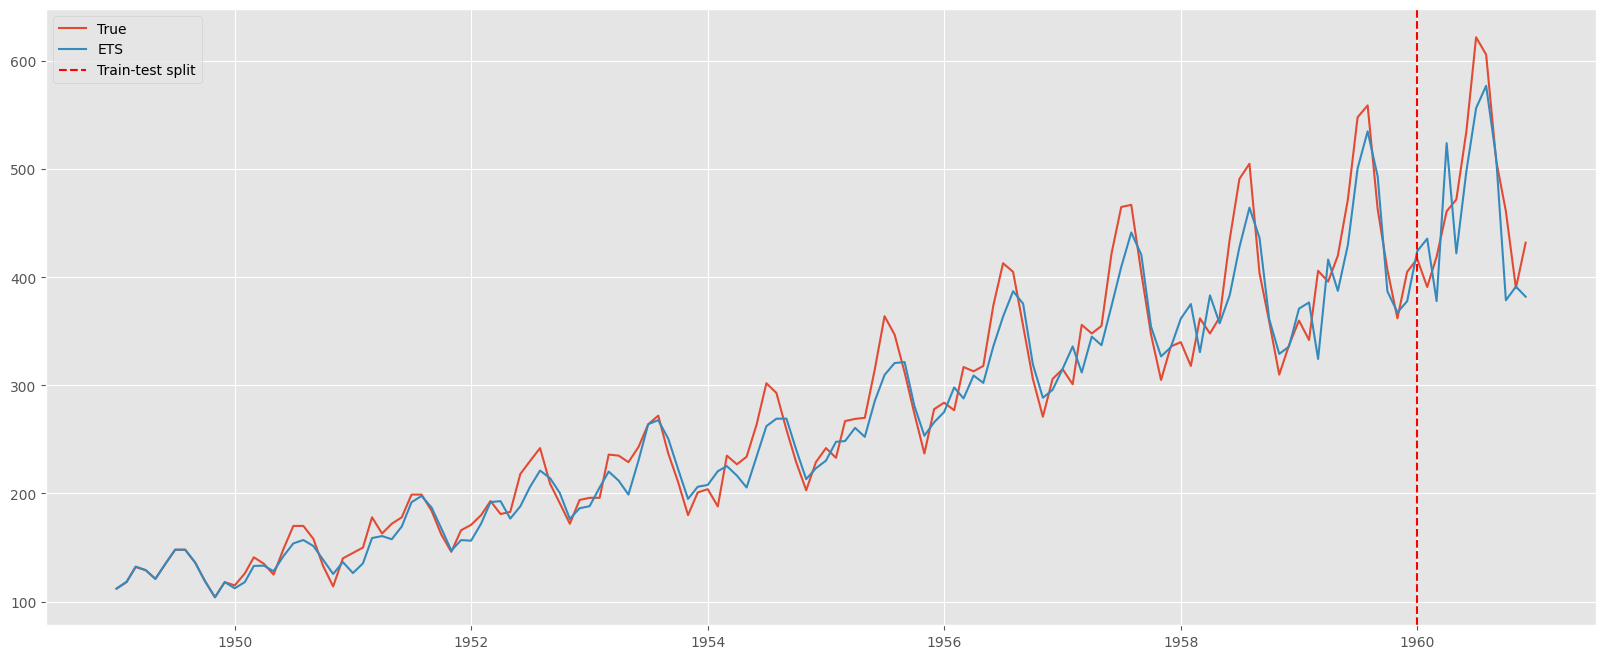

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(y.index, y, label="True")
ax.plot(
    y.index,
    predict(
        jnp.concat(
            [
                y_train,
                jnp.array(n_periods * [jnp.nan])
            ]
        ),
        coeffs,
         initial_state,
    )[1],
    label="ETS",
)
ax.axvline(
    y.index[-12],
    color="red",
    linestyle="dashed",
    label="Train-test split",
)
ax.legend()